# Options IV Calculation Test

This notebook tests the options data fetching and implied volatility (IV) calculation pipeline.


In [343]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [344]:
from adapters.options_adapter import OptionsAdapter
from adapters.rates_adapter import RatesAdapter
from adapters.ticker_adapter import TickerAdapter
from models.options_data import OptionsRequest, OptionType
from datetime import date, datetime, timedelta
from dateutil.relativedelta import relativedelta
from engines.IV_smile import IVEngine


In [345]:
from update_rates import updateRates
updateRates()

FRED_API_KEY present: yes
Starting updateRates...
Starting rate updates...
Updated discount factors: added 1 new records
No new SOFR data available from 2025-12-23
Rate updates completed.
updateRates completed.
Last discount_factors date: 2025-12-22
SOFR update was included.


## Setup

Initialize the adapter and create the options request.


In [372]:
adapter = OptionsAdapter()


today = date.today()
expiry_start = today + relativedelta(weeks=5)
expiry_end = today + relativedelta(weeks=56)

req = OptionsRequest(
    ticker="MSFT",
    optionType=OptionType.CALL,
    expiryStart=expiry_start,
    expiryEnd=expiry_end,
    moneynessMin=0.8,
    moneynessMax=1.2,
)


## Fetch Options Data


In [373]:
print(f"Requesting options for {req.ticker} until {expiry_end}...")
df = adapter.fetch_option_chain(req)
print(f"Fetched {len(df)} contracts.")


Requesting options for MSFT until 2027-01-19...
Fetched 360 contracts.


## Display Options Data


In [374]:
df[["optionType", "strike", "timeToExpiry", "midPrice", "expiry"]]

,optionType,strike,timeToExpiry,midPrice,expiry
0,call,390.0,0.104065,100.395,2026-01-30
1,call,395.0,0.104065,95.030,2026-01-30
2,call,400.0,0.104065,88.960,2026-01-30
3,call,405.0,0.104065,86.040,2026-01-30
4,call,410.0,0.104065,78.965,2026-01-30
...,...,...,...,...,...
355,call,575.0,1.062969,26.465,2027-01-15
356,call,580.0,1.062969,24.685,2027-01-15
357,call,585.0,1.062969,23.405,2027-01-15
358,call,590.0,1.062969,23.045,2027-01-15


## Calculate Implied Volatility


In [375]:
from engines.zero_rates import ZeroRatesEngine

df["rate"] = ZeroRatesEngine.interpolate_zero_rate(df, tte_col="timeToExpiry")

base_info = TickerAdapter.fetchBasic(req.ticker)
div = base_info.dividendYield
spot = base_info.spot
#
#print(f"Spot price: ${spot:.2f}")
#print(f"Risk-free rate: {rate:.4f}")
#print(f"Dividend yield: {div:.4f}%")
#print("\nCalculating IVs...")
#
surface_data = IVEngine.generateIVSmile(df, div/100, spot, OptionType.CALL) #type: ignore
surface_data.dropna(inplace=True)




In [376]:
print("\nIV Calculation Results:")
surface_data[["expiry", "iv"]]



IV Calculation Results:


,expiry,iv
0,2026-01-30,0.560305
1,2026-01-30,0.521560
2,2026-01-30,0.454221
3,2026-01-30,0.507777
4,2026-01-30,0.408531
...,...,...
355,2027-01-15,0.261560
356,2027-01-15,0.258389
357,2027-01-15,0.257657
358,2027-01-15,0.261871


In [377]:
import numpy as np
surface_data["F"] = spot * np.exp((surface_data["rate"] - div/100) * surface_data["T"])
surface_data["k"] = np.log(surface_data["K"] / surface_data["F"])
surface_data["w"] = surface_data["iv"] ** 2 * surface_data["T"]
surface_data[["K", "w", "k", "expiry" ,"F"]]
#print(f"Spot: {spot}")

,K,w,k,expiry,F
0,390.0,0.032670,-0.221275,2026-01-30,486.590012
1,395.0,0.028308,-0.208536,2026-01-30,486.590012
2,400.0,0.021470,-0.195957,2026-01-30,486.590012
3,405.0,0.026832,-0.183535,2026-01-30,486.590012
4,410.0,0.017368,-0.171265,2026-01-30,486.590012
...,...,...,...,...,...
355,575.0,0.072722,0.140901,2027-01-15,499.430887
356,580.0,0.070969,0.149559,2027-01-15,499.430887
357,585.0,0.070567,0.158143,2027-01-15,499.430887
358,590.0,0.072895,0.166653,2027-01-15,499.430887


In [378]:
thetas = surface_data.loc[surface_data["k"].abs().groupby(surface_data["T"]).idxmin()][["T", "k", "w"]].reset_index(drop=True)
thetas

,T,k,w
0,0.104065,-0.003273,0.008120
1,0.161600,-0.004900,0.011992
2,0.238198,0.003190,0.016108
3,0.314910,0.001063,0.021064
4,0.391622,-0.001056,0.030820
5,0.484773,-0.003629,0.034973
6,0.564225,0.004382,0.040091
7,0.660115,-0.008340,0.052180
8,0.736828,0.009808,0.054544
9,0.986257,0.003125,0.075309


In [379]:
from sklearn.isotonic import IsotonicRegression
from scipy.interpolate import PchipInterpolator

In [380]:
iso = IsotonicRegression(increasing=True, out_of_bounds='clip')
theta_iso = iso.fit_transform(thetas["T"], thetas["w"])

theta_spline = PchipInterpolator(thetas["T"], theta_iso, extrapolate=True)
surface_data["theta"] = theta_spline(surface_data["T"])
surface_data[["expiry", "k", "w", "theta"]]

,expiry,k,w,theta
0,2026-01-30,-0.221275,0.032670,0.00812
1,2026-01-30,-0.208536,0.028308,0.00812
2,2026-01-30,-0.195957,0.021470,0.00812
3,2026-01-30,-0.183535,0.026832,0.00812
4,2026-01-30,-0.171265,0.017368,0.00812
...,...,...,...,...
355,2027-01-15,0.140901,0.072722,0.07948
356,2027-01-15,0.149559,0.070969,0.07948
357,2027-01-15,0.158143,0.070567,0.07948
358,2027-01-15,0.166653,0.072895,0.07948


In [381]:
#theta_low = surface_data[surface_data["k"] <0].groupby("T")[["expiry","k","w","K","F","iv"]].max()
#theta_high = surface_data[surface_data["k"] >0].groupby("T")[["expiry","k","w","K","F","iv"]].min()
#interpolated_values = theta_high["w"] - (theta_high["w"] - theta_low["w"]) * (theta_high["k"] / (theta_high["k"] - theta_low["k"]))
#print(theta_high.iloc[-1])
#print(theta_low.iloc[-5:])
#surface_data["theta"] = surface_data["T"].map(interpolated_values)
surface_data[["expiry", "k", "w", "theta"]]




,expiry,k,w,theta
0,2026-01-30,-0.221275,0.032670,0.00812
1,2026-01-30,-0.208536,0.028308,0.00812
2,2026-01-30,-0.195957,0.021470,0.00812
3,2026-01-30,-0.183535,0.026832,0.00812
4,2026-01-30,-0.171265,0.017368,0.00812
...,...,...,...,...
355,2027-01-15,0.140901,0.072722,0.07948
356,2027-01-15,0.149559,0.070969,0.07948
357,2027-01-15,0.158143,0.070567,0.07948
358,2027-01-15,0.166653,0.072895,0.07948


In [382]:
vega = IVEngine._vega(surface_data["iv"], surface_data["K"], surface_data["T"], surface_data["rate"], div, surface_data["F"])
surface_data["vega"] = np.clip(vega, 1e-6, None)
print(f"Spot price: ${spot:.2f}")
surface_data[["expiry", "K", "k", "vega"]]

Spot price: $485.11


,expiry,K,k,vega
0,2026-01-30,390.0,-0.221275,38.492136
1,2026-01-30,395.0,-0.208536,39.239261
2,2026-01-30,400.0,-0.195957,38.487630
3,2026-01-30,405.0,-0.183535,43.743364
4,2026-01-30,410.0,-0.171265,41.980504
...,...,...,...,...
355,2027-01-15,575.0,0.140901,0.541763
356,2027-01-15,580.0,0.149559,0.424561
357,2027-01-15,585.0,0.158143,0.369090
358,2027-01-15,590.0,0.166653,0.402643


In [383]:
T_vals = surface_data["T"].values
T_unique = np.sort(surface_data["T"].unique())
T_to_index = {t: i for i, t in enumerate(T_unique)}
idx = np.array([T_to_index[t] for t in T_vals]) # index for each row to use on T_unique to find eta
x0 = np.r_[ -0.3, np.full(len(T_unique), 0.5) ]    # rho, eta_i-1



In [384]:
def ssvi_w(k, theta, phi, rho):
    w_ssvi = (
        1
        / 2
        * theta
        * (1 + rho * phi * k + np.sqrt((phi * k + rho) ** 2 + 1 - rho**2))
    )
    return w_ssvi


In [385]:
weights = surface_data.groupby("T")["vega"].transform(lambda x: x / x.sum())


In [386]:
def objective(x, theta, k, w_mkt, idx):
    rho_raw = x[0]
    rho = np.tanh(rho_raw) 
    eta = x[1:]
    phi = eta[idx] / np.sqrt(np.maximum(theta, 1e-12))
    w_model = ssvi_w(k, theta, phi, rho)
    error = (w_model - w_mkt)
    loss = np.dot(weights*error, error)*100000
    return loss 

In [387]:
#def butterfly_constraint(x):
#    eta, rho = x
#    return 2 - eta * (1 + abs(rho))

def make_constraints(n_expiries):
    cons = []
    for i in range(n_expiries):
        cons.append({
            "type": "ineq",
            "fun": lambda x, i=i: 2 - x[1+i] * (1 + abs(x[0]))
        })
    return cons


In [388]:
from scipy.optimize import minimize

bounds = [(-99.0, 99.0)] + [(1e-5, 2)] * len(T_unique)
w_mkt = surface_data["w"].values
k = surface_data["k"].values
theta = surface_data["theta"].values


res = minimize(
    objective,
    x0=x0,
    args=(theta, k, w_mkt, idx),
    method="SLSQP",
    bounds=bounds,
    constraints=make_constraints(len(T_unique))
)

#print(res.x)
print(f"Optimised Rho: {np.tanh(res.x[0]):.6f}")
print(f"Optimised Eta: {res.x[1:]}")

surface_data["w_ssvi"] = ssvi_w(k, theta, phi= res.x[1:][idx] / np.sqrt(np.maximum(theta, 1e-12)), rho=np.tanh(res.x[0])) #type: ignore


Optimised Rho: -0.316023
Optimised Eta: [1.48294227 1.30577209 1.10926231 0.96794258 0.9915587  1.13689581
 1.05686021 0.97675977 1.16489181 0.99094913 1.19870694]


In [389]:
surface_data["residuals"] = surface_data["w_ssvi"] - surface_data["w"]
total_residual = np.sum(surface_data["residuals"] ** 2)
print(f"SSVI Total Residual (MSE): {total_residual:.6f}")

SSVI Total Residual (MSE): 0.001765


In [390]:
surface_data["iv_ssvi"] = np.sqrt(surface_data["w_ssvi"] / surface_data["T"])
surface_data["iv_error"] = (surface_data["iv_ssvi"] / surface_data["iv"] - 1)*100
vega_weighted_iv_error = surface_data["iv_error"].abs() * (surface_data["vega"] / np.sum(surface_data["vega"]))
print(f"Vega Weighted Mean IV Error: {np.sum(vega_weighted_iv_error):.4f}%")

Vega Weighted Mean IV Error: 2.8227%


In [391]:
rmse = np.sqrt(np.mean((surface_data["iv_ssvi"] - surface_data["iv"])**2))
print(f"IV RMSE: {rmse:.4f}")
vega_weighted_rmse = np.sqrt(np.sum(((surface_data["iv_ssvi"] - surface_data["iv"])**2) * (surface_data["vega"] / np.sum(surface_data["vega"]))))
print(f"Vega Weighted IV RMSE: {vega_weighted_rmse:.4f}")

IV RMSE: 0.0151
Vega Weighted IV RMSE: 0.0143


In [392]:
surface_data["residuals"] = surface_data["w_ssvi"] - surface_data["w"]
surface_data[["expiry", "K", "iv", "w", "w_ssvi", "residuals"]]

,expiry,K,iv,w,w_ssvi,residuals
0,2026-01-30,390.0,0.560305,0.032670,0.025256,-0.007415
1,2026-01-30,395.0,0.521560,0.028308,0.024160,-0.004148
2,2026-01-30,400.0,0.454221,0.021470,0.023081,0.001611
3,2026-01-30,405.0,0.507777,0.026832,0.022019,-0.004813
4,2026-01-30,410.0,0.408531,0.017368,0.020973,0.003605
...,...,...,...,...,...,...
355,2027-01-15,575.0,0.261560,0.072722,0.071562,-0.001160
356,2027-01-15,580.0,0.258389,0.070969,0.071542,0.000573
357,2027-01-15,585.0,0.257657,0.070567,0.071571,0.001004
358,2027-01-15,590.0,0.261871,0.072895,0.071644,-0.001250


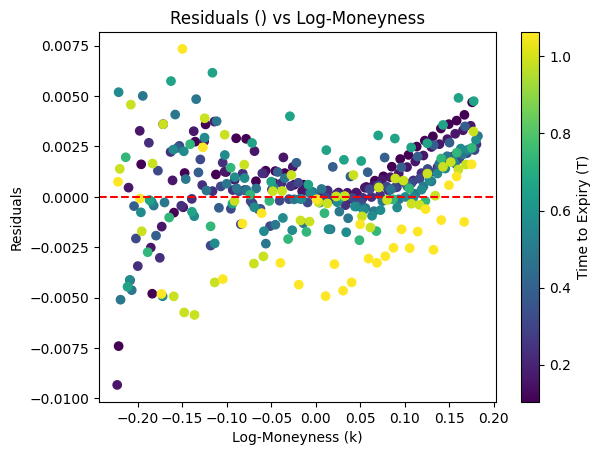

In [367]:
import matplotlib.pyplot as plt
plt.scatter(surface_data["k"], surface_data["residuals"], c=surface_data["T"], cmap="viridis")
plt.colorbar(label="Time to Expiry (T)")
plt.xlabel("Log-Moneyness (k)")
plt.ylabel("Residuals")
plt.title("Residuals () vs Log-Moneyness")
plt.axhline(0, color='red', linestyle='--')
plt.show()

In [368]:
surface_data[["expiry", "K", "iv", "iv_ssvi", "iv_error"]]

,expiry,K,iv,iv_ssvi,iv_error
0,2026-01-30,390.0,0.560299,0.492651,-12.073523
1,2026-01-30,395.0,0.521553,0.481848,-7.613008
2,2026-01-30,400.0,0.454215,0.470965,3.687708
3,2026-01-30,405.0,0.507771,0.459998,-9.408445
4,2026-01-30,410.0,0.408526,0.448941,9.892798
...,...,...,...,...,...
355,2027-01-15,575.0,0.261560,0.259474,-0.797591
356,2027-01-15,580.0,0.258389,0.259439,0.406702
357,2027-01-15,585.0,0.257657,0.259492,0.712327
358,2027-01-15,590.0,0.261871,0.259626,-0.857281


C:\Users\gryph\AppData\Local\Temp\ipykernel_29312\4148399127.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


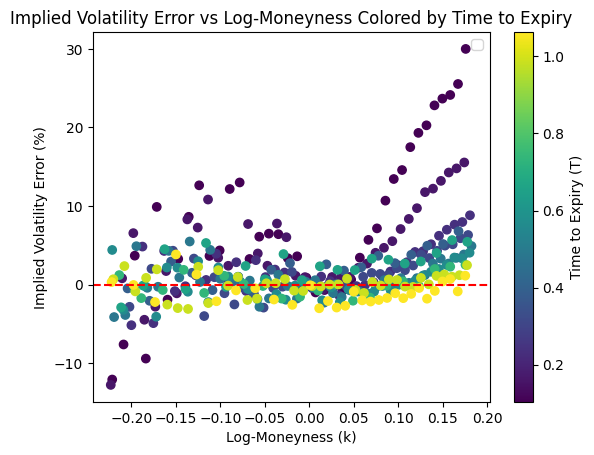

In [369]:
plt.scatter(surface_data["k"], surface_data["iv_error"], c=surface_data["T"], cmap="viridis")
plt.colorbar(label="Time to Expiry (T)")
plt.xlabel("Log-Moneyness (k)")
plt.ylabel("Implied Volatility Error (%)")
plt.title("Implied Volatility Error vs Log-Moneyness Colored by Time to Expiry")
plt.axhline(0, color='red', linestyle='--')
plt.legend()
plt.show()

C:\Users\gryph\AppData\Local\Temp\ipykernel_29312\3882559543.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


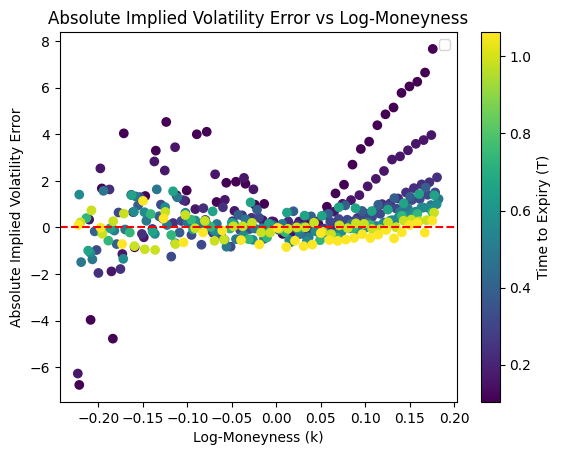

In [370]:
absolute_iv_error = (surface_data["iv_ssvi"] - surface_data["iv"])*100
plt.scatter(surface_data["k"], absolute_iv_error, c=surface_data["T"], cmap="viridis")
plt.colorbar(label="Time to Expiry (T)")
plt.xlabel("Log-Moneyness (k)")
plt.ylabel("Absolute Implied Volatility Error")
plt.title("Absolute Implied Volatility Error vs Log-Moneyness")
plt.axhline(0, color='red', linestyle='--')
plt.legend()
plt.show()
